# Search images with deep learning (keras)

Images are usually very different if we compare them at pixel level but that's quite different if we look at them after they were processed by a deep learning model. We convert each image into a feature vector extracted from an intermediate layer of the network.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Get a pre-trained model

We choose the model described in paper [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861). Pre-trained models are available at [deep-learning-models/releases](https://github.com/fchollet/deep-learning-models/releases/).

In [3]:
from keras.applications.mobilenet import MobileNet
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1,
                  dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None,
                  pooling=None, classes=1000)
model

Using TensorFlow backend.


In [4]:
model.name

'mobilenet_1.00_224'

The model is stored here:

In [5]:
import os
os.listdir(os.path.join(os.environ.get('USERPROFILE', os.environ.get('HOME', '.')), 
                        ".keras", "models"))

['mobilenet_1_0_224_tf.h5']

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [7]:
len(model.layers)

102

## Images

We collect images from [pixabay](https://pixabay.com/).

### Raw images

In [8]:
from pyquickhelper.filehelper import unzip_files
if not os.path.exists('simages'):
    os.mkdir('simages')
files = unzip_files("data/dog-cat-pixabay.zip", where_to="simages")
len(files), files[0]

(31, 'simages\\cat-1151519__480.jpg')

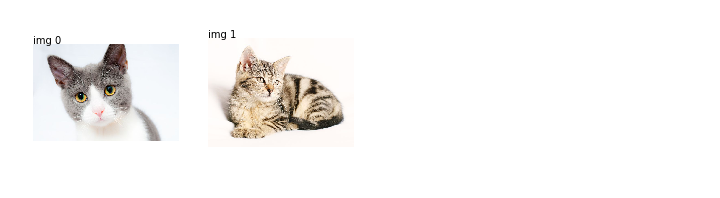

In [9]:
from mlinsights.plotting import plot_gallery_images            
plot_gallery_images(files[:2]);

In [10]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img = load_img('simages/cat-2603300__480.jpg')
x = img_to_array(img)
x.shape

(480, 320, 3)

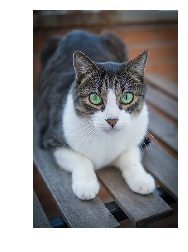

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x / 255)
plt.axis('off');

[keras](https://keras.io/) implements optimized function to load and process images. Below the code with loads the images without modifying them. It creates an iterator which iterates as many times as we want.

In [12]:
params = dict(rescale=1./255)

I suggest trying without the parameter *rescale* to see the differences. The neural network expects numbers in ``[0, 1]`` not in ``[0, 255]``.

In [13]:
from keras.preprocessing.image import ImageDataGenerator
import numpy
augmenting_datagen = ImageDataGenerator(**params)
itim = augmenting_datagen.flow(x[numpy.newaxis, :, :, :])
# zip(range(0,2)) means to stop the loop after 2 iterations
imgs = list(img[0] for i, img in zip(range(0,2), itim))
len(imgs), imgs[0].shape

(2, (480, 320, 3))

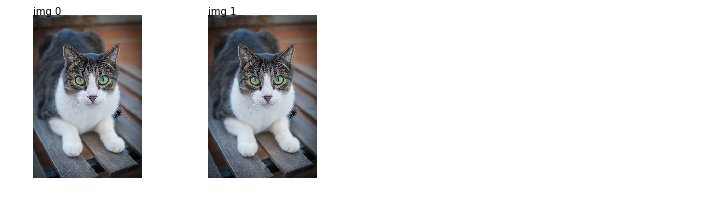

In [14]:
plot_gallery_images(imgs);

But you can multiply the images. See [ImageDataGenerator](https://keras.io/preprocessing/image/) parameters to see what kind of modifications is implemented.

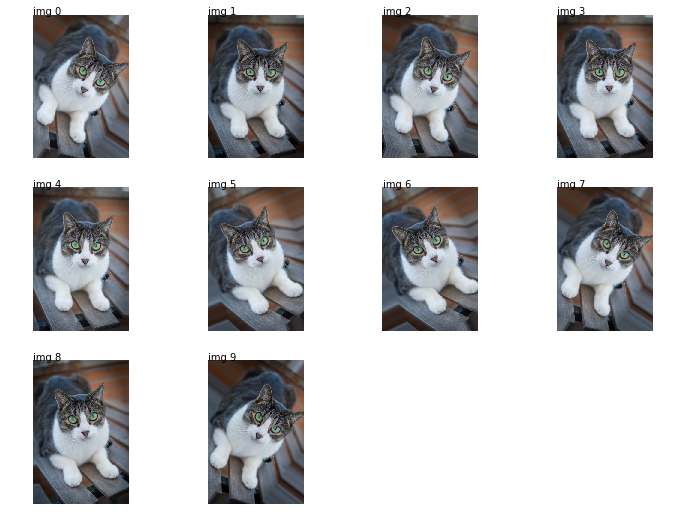

In [15]:
augmenting_datagen_2 = ImageDataGenerator(rotation_range=40, channel_shift_range=9, **params)
itim = augmenting_datagen_2.flow(x[numpy.newaxis, :, :, :])
imgs = list(img[0] for i, img in zip(range(0,10), itim))
plot_gallery_images(imgs);

### Iterator on images

We create an iterator, it considers every subfolder of images. We also need to rescale to size *(224, 224)* which is the size the loaded neural network ingests.

In [16]:
flow = augmenting_datagen.flow_from_directory('.', batch_size=1,
                                              target_size=(224, 224), classes=['simages'])
imgs = list(img[0][0] for i, img in zip(range(0,10), flow))
len(imgs), imgs[0].shape, type(flow)

Found 31 images belonging to 1 classes.


(10, (224, 224, 3), keras_preprocessing.image.DirectoryIterator)

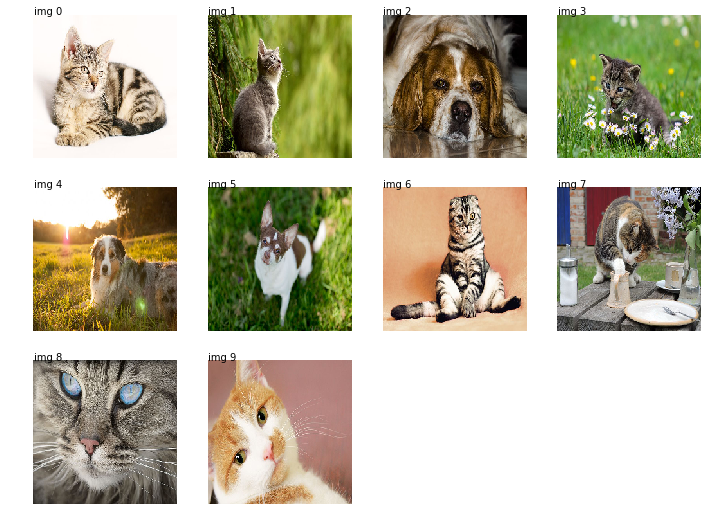

In [17]:
plot_gallery_images(imgs);

How to get the image name?

In [18]:
def get_current_index(flow):
    # The iterator is one step ahead.
    return (flow.batch_index + flow.n - 1) % flow.n

def get_file_index(flow):
    n = get_current_index(flow)
    return flow.index_array[n]

flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224), 
                                              classes=['simages'], shuffle=False)
imgs = list((img[0][0], get_current_index(flow), flow.index_array[get_current_index(flow)], 
             flow.filenames[get_file_index(flow)]) for i, img in zip(range(0,31), flow))
imgs[0][1:]

Found 31 images belonging to 1 classes.


(0, 0, 'simages\\cat-1151519__480.jpg')

In [19]:
imgs[-1][1:]

(30, 30, 'simages\\wolf-2865653__480.jpg')

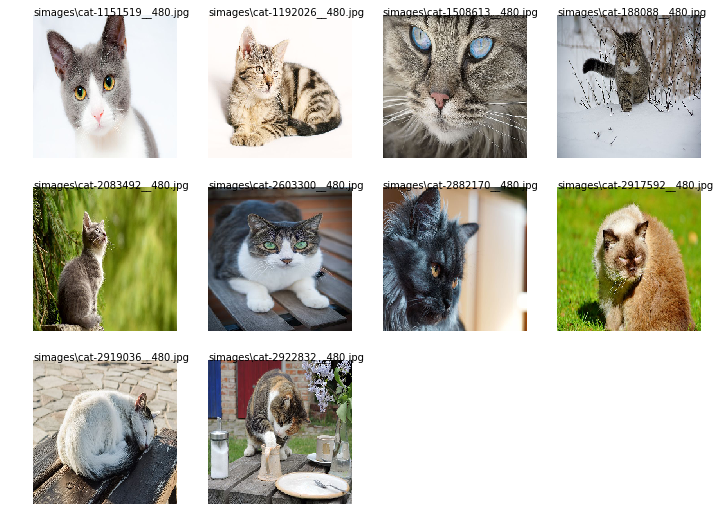

In [20]:
imgs = list((img[0][0], flow.filenames[get_current_index(flow)]) \
            for i, img in zip(range(0,10), flow))
plot_gallery_images([_[0] for _ in imgs], [_[1] for _ in imgs]);

To keep the original order.

Found 31 images belonging to 1 classes.


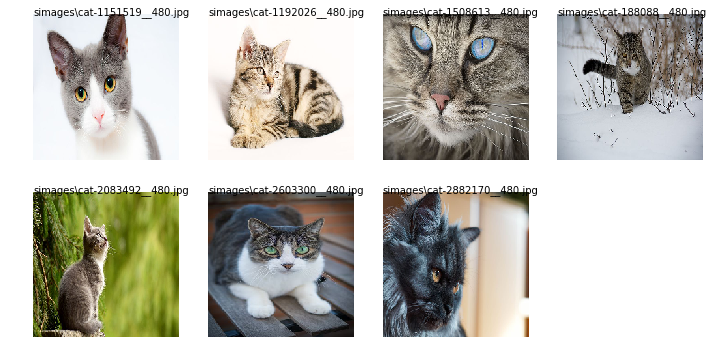

In [21]:
flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224),
                                              shuffle=False, classes=['simages'])
imgs = list((img[0][0], flow.filenames[get_file_index(flow)]) \
            for i, img in zip(range(0,7), flow))
plot_gallery_images([_[0] for _ in imgs], [_[1] for _ in imgs]);

In [22]:
len(flow)

31

## Search among images

We use the class ``SearchEnginePredictionImages``.

### The idea of the search engine

The deep network is able to classify images coming from a competition called [ImageNet](http://image-net.org/) which was trained to classify different images. But still, the network has 88 layers which slightly transform the images into classification results. We assume the last layers contains information which allows the network to classify into objects: it is less related to the images than the content of it. In particular, we would like that an image with a daark background does not necessarily return images with a dark background.

We reshape an image into *(224x224)* which is the size the network ingests. We propagate the inputs until the layer just before the last one. Its output will be considered as the *featurized image*. We do that for a specific set of images called the *neighbors*. When a new image comes up, we apply the same process and find the closest images among the set of neighbors.

In [23]:
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, 
                  dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None, 
                  pooling=None, classes=1000)
model

In [24]:
from keras.models import Model
output = model.layers[len(model.layers)-2].output
model = Model(model.input, output)

In [25]:
flow = augmenting_datagen.flow_from_directory('.', batch_size=1, target_size=(224, 224), 
                                              classes=['simages'], shuffle=False)
imgs = [img[0][0] for i, img in zip(range(0,31), flow)]

Found 31 images belonging to 1 classes.


In [26]:
outputs = [model.predict(im[numpy.newaxis, :, :, :]) for im in imgs]

In [27]:
all_outputs = numpy.stack([o.ravel() for o in outputs])

We have the features. We build the neighbors.

In [28]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors()
knn.fit(all_outputs)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

We extract the neighbors for a new image.

In [29]:
one_image = imgs[5]
one_output = model.predict(one_image[numpy.newaxis, :, :, :])

In [30]:
score, index = knn.kneighbors([one_output.ravel()])
score, index

(array([[0.        , 0.3669334 , 0.40577018, 0.43120632, 0.47972002]]),
 array([[ 5,  2, 10,  3, 28]], dtype=int64))

We need to retrieve images for indexes stored in *index*.

In [31]:
import os
names = os.listdir("simages")
names = [os.path.join("simages", n) for n in names]
disp = [names[i] for i in index.ravel()]
disp

['simages\\cat-2603300__480.jpg',
 'simages\\cat-1508613__480.jpg',
 'simages\\cat-2942887__480.jpg',
 'simages\\cat-188088__480.jpg',
 'simages\\shotlanskogo-2934720__480.jpg']

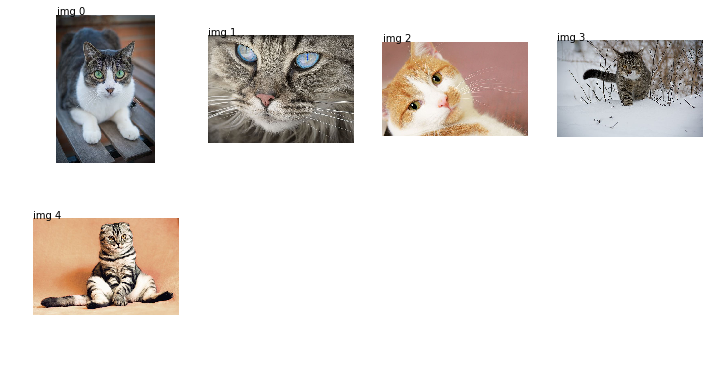

In [32]:
plot_gallery_images(disp);

### Using one intermediate layer close to the output

We do the same but with another code implemented in this module which does the same thing.

In [33]:
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, 
                  dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None, 
                  pooling=None, classes=1000)
model

In [34]:
gen = ImageDataGenerator(rescale=1./255)
iterimf = gen.flow_from_directory(".", batch_size=1, target_size=(224, 224),
                                 classes=['simages'], shuffle=False)

Found 31 images belonging to 1 classes.


In [35]:
from mlinsights.search_rank import SearchEnginePredictionImages
se = SearchEnginePredictionImages(model, fct_params=dict(layer=len(model.layers) - 2), 
                                  n_neighbors=5)

c:\python370_x64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [36]:
se.fit(iterimf)
se.features_.shape

(31, 1000)

In [37]:
se.features_.shape

(31, 1000)

In [38]:
list(se.metadata_)[:5]

['name']

In [39]:
se.metadata_.shape

(31, 1)

Let's choose one image.

In [40]:
name = se.metadata_.iloc[5,0]
name

'simages\\cat-2603300__480.jpg'

In [41]:
img = load_img(name, target_size=(224, 224))
x = img_to_array(img)

In [42]:
gen = ImageDataGenerator(rescale=1./255)
iterim = gen.flow(x[numpy.newaxis, :, :, :], batch_size=1)

In [43]:
score, ind, meta = se.kneighbors(iterim)

In [44]:
score, ind, meta

(array([0.        , 0.3669334 , 0.40577018, 0.43120632, 0.47972002]),
 array([ 5,  2, 10,  3, 28], dtype=int64),
                                      name
 5            simages\cat-2603300__480.jpg
 2            simages\cat-1508613__480.jpg
 10           simages\cat-2942887__480.jpg
 3             simages\cat-188088__480.jpg
 28  simages\shotlanskogo-2934720__480.jpg)

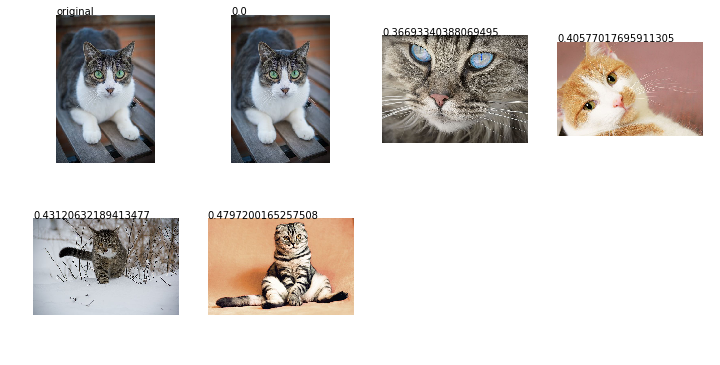

In [45]:
texts = ['original'] + [str(_) for _ in score]
imgs = [name] + list(meta.name)
plot_gallery_images(imgs, texts);

### Using one intermediate layer close to the input

In [46]:
se = SearchEnginePredictionImages(model, fct_params=dict(layer=1), n_neighbors=5)
se.fit(iterimf)
se.features_.shape

(31, 153228)

In [47]:
iterim = gen.flow(x[numpy.newaxis, :, :, :], batch_size=1)
score, ind, meta = se.kneighbors(iterim)

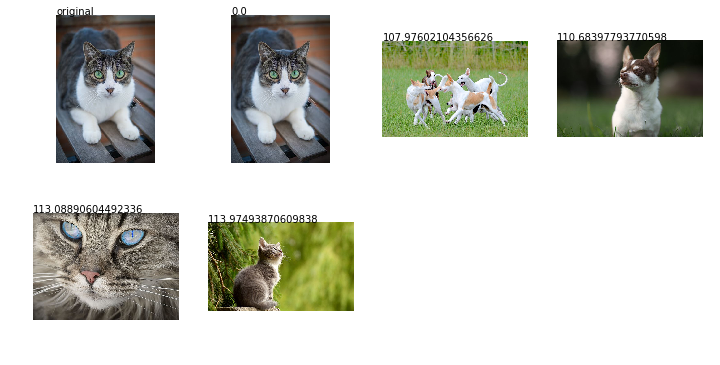

In [48]:
texts = ['original'] + [str(_) for _ in score]
imgs = [name] + list(meta.name)
plot_gallery_images(imgs, texts);

This is worse but expected.

## Going further

The original neural network has not been changed and was chosen to be small (88 layers). Other options are available for better performances. The imported model can be also be trained on a classification problem if there is such information to leverage. Even if the model was trained on millions of images, a couple of thousands are enough to train the last layers. The model can also be trained as long as there exists a way to compute a gradient. We could imagine to label the result of this search engine and train the model on pairs of images ranked in the other.

We can use the [pairwise transform](http://fa.bianp.net/blog/2012/learning-to-rank-with-scikit-learn-the-pairwise-transform/) (example of code: [ranking.py](https://gist.github.com/fabianp/2020955)). For every pair $(X_i, X_j)$, we tell if the search engine should have $X_i \prec X_j$ ($Y_{ij} = 1$) or the order order ($Y_{ij} = 0$). $X_i$ is the features produced by the neural network : $X_i = f(\Omega, img_i)$. We train a classifier on the database:

$$(f(\Omega, img_i) - f(\Omega, img_j), Y_{ij})_{ij}$$

A training algorithm based on a gradient will have to propagate the gradient : $\frac{\partial f}{\partial \Omega}(img_i) - \frac{\partial f}{\partial \Omega}(img_j)$.

**END**